# Entropies & Dimensions


Topics:
* Entropies from **DynamicalSystems.jl**
* Generalized Dimension
* Automated dimension estimation!
* Linear regions

---
# Entropies

* In the study of dynamical systems there are many quantities that identify as "entropy".
* These quantities are not the more commonly known [thermodynamic ones](https://en.wikipedia.org/wiki/Entropy), used in Statistical Physics. 
* Rather, they are more like the to the entropies of [information theory](https://en.wikipedia.org/wiki/Entropy_(information_theory)), which represents information contained within a dataset, or information about the dimensional scaling of a dataset.

There are two functions that give entropies from **DynamicalSystems.jl**. The first is the `genentropy` (which stands for "generalized entropy").

In [5]:
using DynamicalSystems

In [6]:
?genentropy

search: genentropy



```julia
genentropy(α, ε, dataset::AbstractDataset; base = e)
```

Compute the `α` order generalized (Rényi) entropy [1] of a dataset, by first partitioning it into boxes of length `ε` using [`non0hist`](@ref).

```julia
genentropy(α, p::AbstractArray; base = e)
```

Compute the entropy of an array `p` directly, assuming that `p` is sum-normalized.

Optionally use `base` for the logarithms.

## Description

The Rényi entropy

$$
R_\alpha(p) = \frac{1}{1-\alpha}\sum_i p[i]^\alpha
$$

generalizes other known entropies, like e.g. the information entropy ($\alpha = 1$, see [2]), the maximum entropy ($\alpha=0$, also known as Hartley entropy), or the correlation entropy ($\alpha = 2$, also known as collision entropy).

The following aliases are provided:

  * `renyi = genentropy`
  * `shannon(args...) = genentropy(1, args...)`
  * `hartley(args...) = genentropy(0, args...)`

## References

[1] : A. Rényi, *Proceedings of the fourth Berkeley Symposium on Mathematics, Statistics and Probability*, pp 547 (1960)

[2] : C. E. Shannon, Bell Systems Technical Journal **27**, pp 379 (1948)


---



In [3]:
# entropy of a coin toss:
y = Float64.(rand(Bool, 1000000)) # just some coin tosses
sh = shannon(0.1, y)  # ≡ genentropy(1, 0.0, y)

0.6931471625099452

The above number should be log(2) [by definition](https://en.wikipedia.org/wiki/Shannon_(unit)

In [9]:
isapprox(sh, log(2),  rtol = 1e-6)

true

In [3]:
towel = Systems.towel()
N = 100000 # amount of points in data
tr = trajectory(towel, N)
genentropy(1, 0.01, tr) # The result is with log base-e !

9.47195808007415

How much time does it take?

In [4]:
using BenchmarkTools
@btime shannon(0.01, $tr);

  20.101 ms (42 allocations: 3.05 MiB)


The other function of **DynamicalSystems.jl** which calculates some entropy, the permutation entropy, is called `permentropy`. This won't be discussed here but is of course available in the [documentation](https://juliadynamics.github.io/DynamicalSystems.jl/latest/chaos/entropies/#permutation-entropy) along with an example application.

# Attractor Dimension
* There are numerous methods that one can use to calculate a so-called "dimension" of a
dataset, like for example the [Fractal dimension](https://en.wikipedia.org/wiki/Fractal_dimension).

* Most of the time these dimensions indicate some kind of scaling behavior. 

* For example, the scaling of `genentropy` with decreasing `ε` gives the so-called "generalized dimension".

* $ E \approx -D\log(\varepsilon)$ with $E$ the entropy and $D$ the "dimension".


In [26]:
# I want to know dimension of attractor of the Towel Map!
towel = Systems.towel()
tr = trajectory(towel, 1000000)
# more points = more precision = more computations = more time!

3-dimensional Dataset{Float64} with 1000001 points:
 0.085     -0.121       0.075   
 0.285813  -0.0675286   0.238038
 0.76827   -0.038933    0.672094
 0.681871   0.0508933   0.825263
 0.837347   0.0372633   0.555269
 0.51969    0.0616256   0.940906
 0.966676  -0.00171595  0.2225  
 0.112748   0.0674955   0.653573
 0.386547  -0.0886542   0.869349
 0.910741  -0.0316828   0.411607
 0.306095   0.0689305   0.909129
 0.824263  -0.056185    0.326064
 0.545332   0.0508239   0.819404
 ⋮                              
 0.759127   0.0250481   0.433977
 0.692366   0.0420435   0.933533
 0.826378   0.0422742   0.242956
 0.53513    0.0455146   0.703704
 0.953367   0.00194466  0.797251
 0.179403   0.0981167   0.611396
 0.564419  -0.0724939   0.917717
 0.945822   0.00891811  0.270937
 0.186499   0.0666002   0.748448
 0.586876  -0.0779306   0.724994
 0.927441   0.0129152   0.738062
 0.264358   0.0893829   0.733358


In [42]:
# I want to compute `genentropy` for different ε.
# Which ε to use?...
# Let's do a random logspace based guess...
ες = logspace(-2, 0, 8)

8-element Array{Float64,1}:
 0.01     
 0.019307 
 0.0372759
 0.0719686
 0.13895  
 0.26827  
 0.517947 
 1.0      

In [44]:
Es = zeros(ες)
for (i, ε) ∈ enumerate(ες)
    Es[i] = genentropy(1, ε, tr)
end
Es

8-element Array{Float64,1}:
  9.57773
  8.17065
  6.78695
  5.39409
  4.20973
  2.71988
  1.34766
 -0.0    

Alright. Remember that it should be that $\log(E) \approx -D\log(\varepsilon)$
 with $E$ the entropy and $D$ the "dimension". 

Let's plot and see:

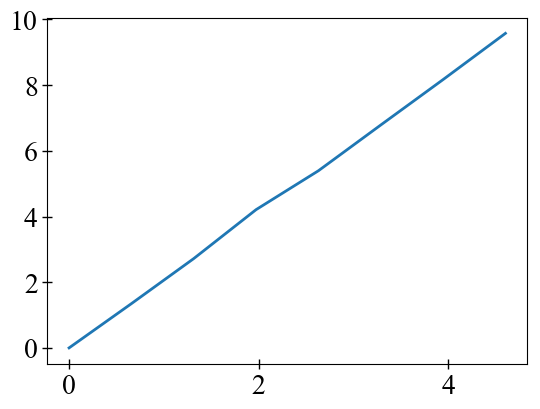

In [45]:
using PyPlot; figure(figsize = (6,4))
plot(-log.(ες), Es); xlabel("ε"); ylabel("E");

What typically happens is that there is some region where this scaling behavior holds, but then it stops holding due to the finite amount of data points.

In [46]:
# Find the slope of the curve there.
offset, slope = linreg(-log.(ες), Es)
D = slope

2.072753353465525

This is actually a correct result, the information dimension of the attractor of the towel map is around 2.

---

* Are the values of `ες` we used good? 
* For a general dataset, how to determine them?

the function `estimate_boxsizes(dataset; kwargs...)` can help with that!

In [55]:
?estimate_boxsizes

search: estimate_boxsizes



```
estimate_boxsizes(dataset::AbstractDataset; k::Int = 12, z = -1, w = 1)
```

Return a `k`-element `logspace` from `lower + w` to `upper + z`,

`lower` is the magnitude of the minimum pair-wise distance between datapoints while `upper` is the magnitude of the maximum difference between greatest and smallest number among each timeseries.

"Magnitude" here stands for order of magnitude, i.e. `round(log10(x))`.


In [62]:
ες = estimate_boxsizes(tr)

12-element Array{Float64,1}:
 0.0001     
 0.000187382
 0.000351119
 0.000657933
 0.00123285 
 0.00231013 
 0.00432876 
 0.00811131 
 0.0151991  
 0.0284804  
 0.053367   
 0.1        

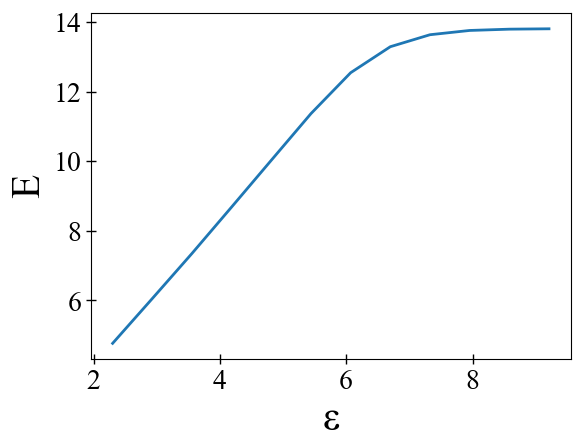

PyObject <matplotlib.text.Text object at 0x000000002D6C28D0>

In [68]:
# plot this scaling thingy again
Es = zeros(ες)
for (i, ε) ∈ enumerate(ες)
    Es[i] = genentropy(1, ε, tr)
end
figure(figsize = (6,4))
plot(-log.(ες), Es); xlabel("ε"); ylabel("E");

---

* Given some arbitrary plot like the one above, is there any algorithm to deduce a scaling region???

**I GOT YOU COVERED**

The function `linear_regions(x, y; kwargs...)` decomposes the function `y(x)` to regions where linear scaling holds!

It returns the indices of `x` that correspond to linear regions and the approximated tangents at each region!

In [63]:
x = -log.(ες)
lrs, slopes = linear_regions(x, Es)

([1, 2, 3, 4, 5, 6, 12], [0.0169754, 0.059061, 0.195576, 0.549296, 1.19167, 1.87214])

In [64]:
for i in 1:length(slopes)
    println("linear region $(i) starts from index $(lrs[i]) and ends at index $(lrs[i+1])")
    println("with corresponding slope $(slopes[i])")
    println()
end

linear region 1 starts from index 1 and ends at index 2
with corresponding slope 0.016975404756333783

linear region 2 starts from index 2 and ends at index 3
with corresponding slope 0.05906099241097322

linear region 3 starts from index 3 and ends at index 4
with corresponding slope 0.19557558744176076

linear region 4 starts from index 4 and ends at index 5
with corresponding slope 0.5492959963318317

linear region 5 starts from index 5 and ends at index 6
with corresponding slope 1.191671329759043

linear region 6 starts from index 6 and ends at index 12
with corresponding slope 1.8721371361873942



In [67]:
# The linear region which is biggest is "probably correct one"
# Here it is the last one, thus the slope is
slopes[end]

1.8721371361873942

This `linear_regions` function is cool! Is there any "easy" way to visualize what it does?

**SAY NO MORE**

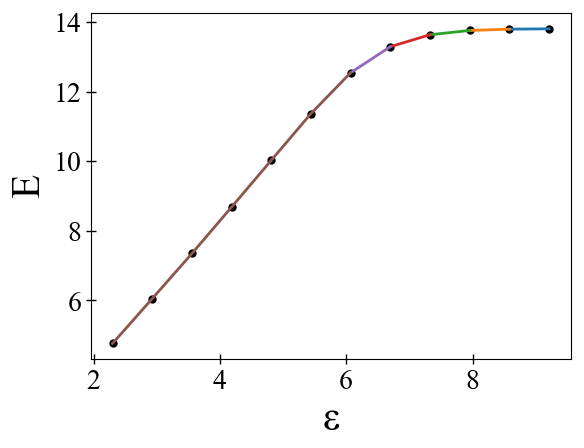

In [73]:
using PyPlot, ChaosTools # ChaosTools belongs to DynamicalSystems
# ChaosTools brings a function `plot_linear_regions`
figure(figsize=(6,4))
plot_linear_regions(x, Es)
xlabel("ε"); ylabel("E");

# `generalized_dim` function

Let's summarize what we just did to estimate the dimension of an attractor.

1. We decided on some partition sizes `ες` to use.
    * The function `estimate_boxsizes` can help with that.
2. For each `ε in ες` we calculated the `genentropy`, and got an array `Es`.
3. We tried to find a "linear scaling region" of the curve `Es` vs. `-log.(ες)`.

Wouldn't it be **just pure magic** if all of this process could happen with one function call?

In [74]:
generalized_dim(2.0, tr)

2.0254102331734276

In [76]:
information_dim(tr) # ≡ generalized_dim(1, tr)

2.0857728648406897

In [81]:
# Let's do the same for the Henon map that we have seen in previous tutorials
hen = Systems.henon()
tr = trajectory(hen, 200000)
information_dim(tr)

1.2158849315035678

In [95]:
# Same for the lorenz system
ds = Systems.lorenz()
tr_lor = trajectory(ds, 1000.0; dt = 0.05);

In [96]:
capacity_dim(tr_lor)

1.7205477624869332

The above is a *wrong* result. It is known that the capacity dimension of the Lorenz attractor (for default parameters) is around 2.0 (Grassberger and Procaccia, 1983)!

**It is important to understand that `generalized_dim` is not magic. I was just lying before.**

In [ ]:
I STOPPED HERE

In [5]:
?generalized_dim

search: generalized_dim



```
generalized_dim(α, dataset [, sizes]) -> D_α
```

Return the `α` order generalized dimension of the `dataset`, by calculating the [`genentropy`](@ref) for each `ε ∈ sizes`.

## Description

The returned dimension is approximated by the (inverse) power law exponent of the scaling of the [`genentropy`](@ref) versus the box size `ε`, where `ε ∈ sizes`.

Calling this function performs a lot of automated steps:

1. A vector of box sizes is decided by calling `sizes = estimate_boxsizes(dataset)`, if `sizes` is not given.
2. For each element of `sizes` the appropriate entropy is calculated, through `d = genentropy.(α, sizes, dataset)`. Let `x = -log.(sizes)`.
3. The curve `d(x)` is decomposed into linear regions, using [`linear_regions`](@ref)`(x, d)`.
4. The biggest linear region is chosen, and a fit for the slope of that region is performed using the function [`linear_region`](@ref). This slope is the return value of `generalized_dim`.

By doing these steps one by one yourself, you can adjust the keyword arguments given to each of these function calls, refining the accuracy of the result.

The following aliases are provided:

  * α = 0 : `boxcounting_dim`, `capacity_dim`
  * α = 1 : `information_dim`
  * α = 2 : `correlation_dim`


---

The reason this function discribes so verbosely exactly what it does, is because it is very easy for someone to misjudge the result (just like the example of the previous tutorial involving the Shinriki oscillator).

I will now show some examples where **I know that the parameters used return valid results**.

In [6]:
# calculate dimension of towel map attractor:
generalized_dim(1.0, tr)

2.045145949138133

In [7]:
generalized_dim(2.0, tr) # should be smaller from the above

1.912017038451262

which confirms what we stated  expected from the result of the tutorial on "Orbit Diagrams, Surfaces of Section".

---

The functions used internally by `generalized_dim` can be very helpful in their own right! For example the function:

In [10]:
?linear_regions

search: linear_regions linear_region



```
linear_regions(x, y; dxi::Int = 1, tol = 0.2) -> (lrs, tangents)
```

Identify regions where the curve `y(x)` is linear, by scanning the `x`-axis every `dxi` indices (e.g. at `x[1] to x[5], x[5] to x[10], x[10] to x[15]` and so on if `dxi=5`).

If the slope (calculated using `LsqFit`) of a region of width `dxi` is approximatelly equal to that of the previous region, within tolerance `tol`, then these two regions belong to the same linear region.

Return the indices of `x` that correspond to linear regions, `lrs`, and the approximated `tangents` at each region. `lrs` is a vector of `Int`.

A function `plot_linear_regions` visualizes the result of using this `linear_regions` (requires `PyPlot`).


Let's see how it behaves.

First, let's follow the same approach that `generalized_dim` does!

In [11]:
tr = trajectory(towel, 1000000) # suuuuper precise computation
sizes = estimate_boxsizes(tr) # I use the towel map trajectory, makes no difference though

12-element Array{Float64,1}:
 0.0001     
 0.000187382
 0.000351119
 0.000657933
 0.00123285 
 0.00231013 
 0.00432876 
 0.00811131 
 0.0151991  
 0.0284804  
 0.053367   
 0.1        

In [12]:
Ds = zeros(sizes)
for (i, s) in enumerate(sizes)
    Ds[i] = genentropy(1, s, tr)
end
x = -log.(sizes);

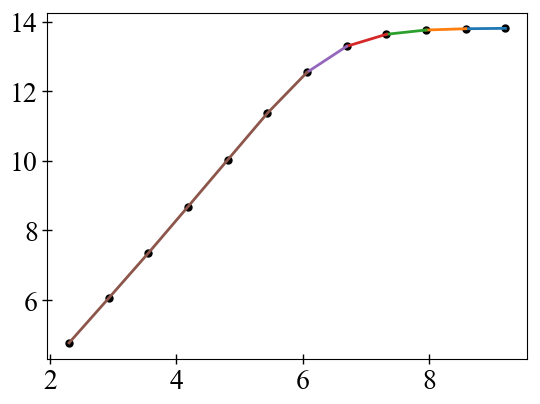

In [13]:
using PyPlot # brings plot_linear_regions into scope
using ChaosTools # you must use ChaosTools as well, for Requires module to work
figure(figsize = (6,4))
plot_linear_regions(x, Ds);

What `generalized_dim` does is calculates the above plot and simply returns the slope of the brown region.

## Kaplan-Yorke Dimension
The Kaplan-Yorke dimension is simply the point where `cumsum(lyapunovs)` becomes zero (interpolated). Kaplan & Yorke have conjectured that this dimension is equal to the information dimension (the dimension when using `α = 1`). But numerical simulations show that this is not always the case...

In [14]:
ls = lyapunovs(towel, 100000; Ttr = 100) # super precise computation

3-element Array{Float64,1}:
  0.431184
  0.376682
 -3.30098 

In [15]:
information_dim(tr) # shorthand for generalized_dim(1, ...)

2.0857728648406897

In [16]:
kaplanyorke_dim(ls)

2.244735099071937

# Docstrings

In [33]:
?estimate_boxsizes

search: estimate_boxsizes



```
estimate_boxsizes(dataset::AbstractDataset; k::Int = 12, z = -1, w = 1)
```

Return a `k`-element `logspace` from `lower + w` to `upper + z`,

`lower` is the magnitude of the minimum pair-wise distance between datapoints while `upper` is the magnitude of the maximum difference between greatest and smallest number among each timeseries.

"Magnitude" here stands for order of magnitude, i.e. `round(log10(x))`.


In [34]:
?linear_regions

search: linear_regions linear_region



```
linear_regions(x, y; dxi::Int = 1, tol = 0.2) -> (lrs, tangents)
```

Identify regions where the curve `y(x)` is linear, by scanning the `x`-axis every `dxi` indices (e.g. at `x[1] to x[5], x[5] to x[10], x[10] to x[15]` and so on if `dxi=5`).

If the slope (calculated using `LsqFit`) of a region of width `dxi` is approximatelly equal to that of the previous region, within tolerance `tol`, then these two regions belong to the same linear region.

Return the indices of `x` that correspond to linear regions, `lrs`, and the approximated `tangents` at each region. `lrs` is a vector of `Int`.

A function `plot_linear_regions` visualizes the result of using this `linear_regions` (requires `PyPlot`).


In [35]:
?generalized_dim

search: generalized_dim



```
generalized_dim(α, dataset [, sizes]) -> D_α
```

Return the `α` order generalized dimension of the `dataset`, by calculating the [`genentropy`](@ref) for each `ε ∈ sizes`.

## Description

The returned dimension is approximated by the (inverse) power law exponent of the scaling of the [`genentropy`](@ref) versus the box size `ε`, where `ε ∈ sizes`.

Calling this function performs a lot of automated steps:

1. A vector of box sizes is decided by calling `sizes = estimate_boxsizes(dataset)`, if `sizes` is not given.
2. For each element of `sizes` the appropriate entropy is calculated, through `d = genentropy.(α, sizes, dataset)`. Let `x = -log.(sizes)`.
3. The curve `d(x)` is decomposed into linear regions, using [`linear_regions`](@ref)`(x, d)`.
4. The biggest linear region is chosen, and a fit for the slope of that region is performed using the function [`linear_region`](@ref). This slope is the return value of `generalized_dim`.

By doing these steps one by one yourself, you can adjust the keyword arguments given to each of these function calls, refining the accuracy of the result.

The following aliases are provided:

  * α = 0 : `boxcounting_dim`, `capacity_dim`
  * α = 1 : `information_dim`
  * α = 2 : `correlation_dim`
